# CNN & More

## Easy, but Important!

---

### 내가 만든 모델을 저장하고, 불러오는 것

### 라이브러리 로딩

In [1]:
'''
라이브러리들을 불러오자.
'''
import random as rd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.backend import clear_session
from tensorflow.keras.layers import Input, Dense, BatchNormalization, Dropout, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint # 콜백스의 모델체크포인트! 오늘부터 사용할 것

from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
(train_x, train_y), (test_x, test_y) = tf.keras.datasets.mnist.load_data()

11490434/11490434 [==============================] - 0s 0us/step


In [3]:
print(train_x.shape, train_y.shape, test_x.shape, test_y.shape)

(60000, 28, 28) (60000,) (10000, 28, 28) (10000,)


id = 3196
다음 그림은 숫자 1 입니다.


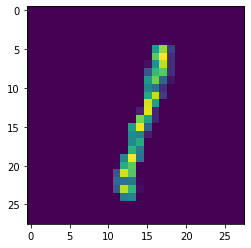

In [4]:
'''
Ctrl+Enter를 이용하여
반복 실행 해보자!
'''

id = rd.randrange(0,10000)

print(f'id = {id}')
print(f'다음 그림은 숫자 {test_y[id]} 입니다.')

plt.imshow(test_x[id])
plt.show()

### Convolutional Layer를 위한 reshape!

* One-Hot Encoding

In [5]:
from tensorflow.keras.utils import to_categorical

In [6]:
class_n = len(np.unique(train_y))
class_n

10

In [7]:
train_y = to_categorical(train_y, class_n)
test_y = to_categorical(test_y, class_n)



In [8]:
train_y.shape

(60000, 10)

In [9]:
# x : 흑백을 명시하기 위한 reshape
train_x = np.expand_dims(train_x, axis=-1)
test_x = np.expand_dims(test_x, axis=-1)
# expand_dims라고 차원을 추가하는 함수가 있습니다! 이거 아셔야 합니다. 
print(train_x.shape, train_y.shape, test_x.shape, test_y.shape)

(60000, 28, 28, 1) (60000, 10) (10000, 28, 28, 1) (10000, 10)


* 이미지 값을 0 ~ 1 사이 값을 갖도록 스케일 조정!

In [10]:
print('max :', train_x.max(),'  min :', train_x.min())

max : 255   min : 0


In [11]:
# min-max scaling
# train_x = train_x/255
# test_x = test_x/255

max_v, min_v = train_x.max(), train_x.min()
max_v, min_v

(255, 0)

In [12]:
train_x = (train_x - min_v) / (max_v - min_v)
test_x = (test_x - min_v) / (max_v - min_v)

In [13]:
print('max :', train_x.max(),'  min :', train_x.min())

max : 1.0   min : 0.0


### Sequential API 모델링

CNN에 관한 것만 추가가 된다.
[여기](https://keras.io/layers/convolutional/)를 적극적으로 참고하자

In [14]:
# 혹시 이미 그려둔 그래프가 있다면 날려줘!
clear_session()

# model에 순차적으로 레이어를 쌓아가겠다는 의도!
model = keras.models.Sequential()

model.add( Input(shape=(28,28,1)) )
model.add( Conv2D(filters=32,
                  kernel_size=(3, 3),
                  activation='relu') )
model.add( Conv2D(filters=32,
                  kernel_size=(3,3),
                  activation='relu') )
model.add( MaxPool2D((2,2)) )
model.add( Dropout(0.20) )

model.add( Conv2D(filters=64,
                  kernel_size=(3, 3),
                  activation='relu',
                  padding='same') )
model.add( Conv2D(filters=64,
                  kernel_size=(3, 3),
                  activation='relu',
                  padding='same') )
model.add( MaxPool2D((2,2)) )
model.add( Dropout(0.25) )

model.add( Conv2D(filters=128,
                  kernel_size=(3, 3),
                  activation='relu',
                  padding='same') )
model.add( Dropout(0.25) )

model.add( Flatten() )
model.add( Dense(128, activation = 'relu') )
model.add( BatchNormalization()  )
model.add( Dropout(0.25) )
model.add( Dense(10, activation = 'softmax') )

# 모델 구조 확인
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 32)        9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 12, 12, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 12, 12, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 12, 12, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 12, 12, 64)        36928     
                                                        



1.   똑같은 모듈이 2개가 있음 
2.   



In [15]:
# 모델 컴파일

model.compile(loss = keras.losses.categorical_crossentropy, metrics=['accuracy'],
              optimizer = 'adam')

### **Data Augmentation**

In [16]:
datagen = ImageDataGenerator(
    featurewise_center=False,  # set input mean to 0 over the dataset
    samplewise_center=False,  # set each sample mean to 0
    featurewise_std_normalization=False,  # divide inputs by std of the dataset
    samplewise_std_normalization=False,  # divide each input by its std
    zca_whitening=False,  # apply ZCA whitening
    rotation_range=15, # randomly rotate images in the range (degrees, 0 to 180)
    zoom_range = 0.1, # Randomly zoom image 
    width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
    horizontal_flip=False,  # randomly flip images
    vertical_flip=False)  # randomly flip images

### Real-time data augmentation 을 위하여!

* validation set을 따로 만들어 두자. - (원래라면 스케일링 전에 분리했어야 함)

In [17]:
train_x, val_x, train_y, val_y = train_test_split(train_x, train_y, test_size=0.1, random_state=2023)

* Early Stopping 적용

In [18]:
es = EarlyStopping(monitor='val_loss', # 개선 대상
                   min_delta=0,        # 개선되고 있다고 판단하기 위한 최소 변화량
                   patience=5,         # 개선없는 epoch를 얼마나 기다려줄거야?
                   verbose=1,
                   restore_best_weights=True)

* 모델 체크포인트

In [19]:
mcp = ModelCheckpoint(filepath='/content/model_save.h5', # 모델 저장 경로 > 저장되는 경로를 설정 (tensorflow 측에서 h5 확장자 권장)
                      monitor='val_loss',                # 모델 저장의 관심 대상
                      verbose=1,                         # 어느 시점에서 저장되는지 알려줌
                      save_best_only=True,               # 최고 성능 모델만 저장 >  제일 좋은 것만 저장
                      save_weights_only=False)           # 가중치만 저장할 것인지, 모델 구조도 저장할 것인지

* training

In [20]:
# 데이터를 넣어서 학습시키자!
datagen.fit(train_x)    

history = model.fit(datagen.flow(train_x, train_y, batch_size=1024),
                    epochs=10000, validation_data=(val_x, val_y),
                    verbose=1, callbacks=[es, mcp])

Epoch 1/10000
53/53 [==============================] - ETA: 0s - loss: 0.6380 - accuracy: 0.7919
Epoch 1: val_loss improved from inf to 1.22270, saving model to /content/model_save.h5
53/53 [==============================] - 30s 319ms/step - loss: 0.6380 - accuracy: 0.7919 - val_loss: 1.2227 - val_accuracy: 0.9622
Epoch 2/10000
53/53 [==============================] - ETA: 0s - loss: 0.1467 - accuracy: 0.9561
Epoch 2: val_loss improved from 1.22270 to 0.93170, saving model to /content/model_save.h5
53/53 [==============================] - 16s 310ms/step - loss: 0.1467 - accuracy: 0.9561 - val_loss: 0.9317 - val_accuracy: 0.9797
Epoch 3/10000
53/53 [==============================] - ETA: 0s - loss: 0.1000 - accuracy: 0.9708
Epoch 3: val_loss improved from 0.93170 to 0.57517, saving model to /content/model_save.h5
53/53 [==============================] - 20s 374ms/step - loss: 0.1000 - accuracy: 0.9708 - val_loss: 0.5752 - val_accuracy: 0.9890
Epoch 4/10000
53/53 [=======================

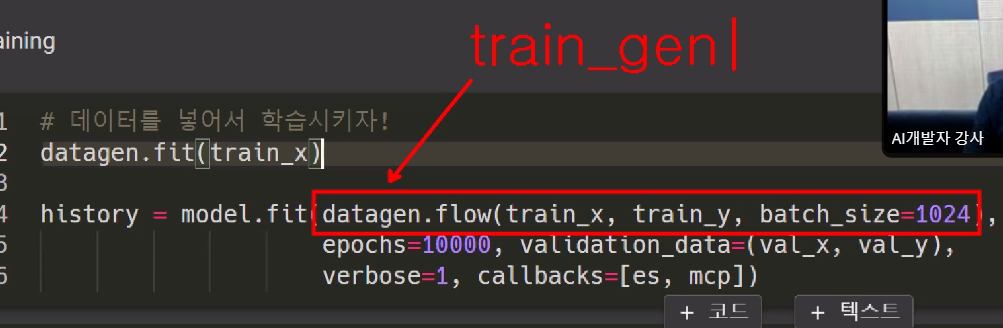

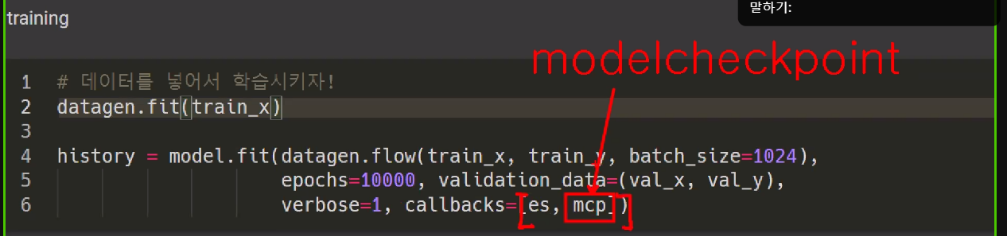

- 최적이 될지 아닐지 모르니까 현시점에서 가장 최선을 선택
- 최적치가 나오면 저장하고 새로 최고치 나오고 갱신하고 >> 덮어씌운다고 생각하면 됨
- 모든 에포크에 대한 기록이 남아야 되는데 그러면 용량을 많이 차지할 테니까 블라블라블ㄹ라

In [21]:
performance_test = model.evaluate(test_x, test_y, batch_size=1024)

print('Test Loss : {:.6f},  Test Accuracy : {:.3f}%'.format(performance_test[0], performance_test[1]*100))

10/10 [==============================] - 1s 54ms/step - loss: 0.0120 - accuracy: 0.9958
Test Loss : 0.011963,  Test Accuracy : 99.580%


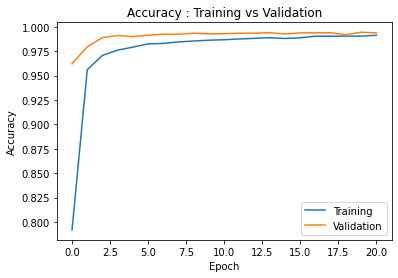

In [22]:
if not isinstance(history, dict):
    history = history.history

plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.title('Accuracy : Training vs Validation')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc=0)
plt.show()

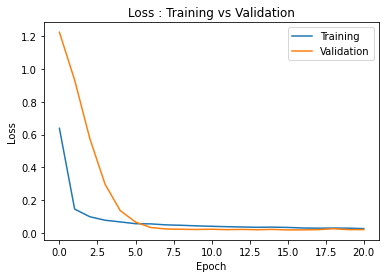

In [23]:
if not isinstance(history, dict):
    history = history.history

plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('Loss : Training vs Validation')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc=0)
plt.show()

## Model Save & Load

In [24]:
model.save('my_first_save.h5') # 얘는 학습 이후에 저장이 가능 / 덮어 씌웠기 때문에 어쨌든 같은 가중치를 가진 모델이 됨

In [33]:
clear_session() # 메모리단에서 모델 구조 자체를 날려버리기~ 약간 초기화해주고 후에 덮어씌운다고 생각하셈

In [38]:
# model = keras.models.load_model('my_first_save.h5')
model = keras.models.load_model('model_save.h5') # 새롭게 에포크 만들 때마다 저장한 거 >> ??? =  False를 주지않으면 새롭게 바뀌는 에폭스에 대해서 모두 저장해서 용량이 어마어마해짐

model.save는 해당 시점에서 model 변수에 들어있는 모델을 저장하는 거고(학습이 종료된 후의 모델) checkpoint는 모델 성능이 갱신될 때마다 가장 좋은 모델을 저장합니다. 이번 강의의 경우에는 EarlyStopping 콜백을 주었기 때문에 학습을 마쳤을 경우에 model 변수에는 가장 좋은 모델이 들어있기에 학습 종료 후 model.save했을 때 저장되는 모델과 checkpoint 콜백으로 자동 저장된 모델이 모두 가장 좋은 성능의 모델로 똑같습니다.

In [39]:
# 모델에 대한 구조
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 32)        9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 12, 12, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 12, 12, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 12, 12, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 12, 12, 64)        36928     
                                                        

In [40]:
pred_train = model.predict(train_x)
pred_test = model.predict(test_x)

single_pred_train = pred_train.argmax(axis=1)
single_pred_test = pred_test.argmax(axis=1)

logi_train_accuracy = accuracy_score(train_y.argmax(axis=1), single_pred_train)
logi_test_accuracy = accuracy_score(test_y.argmax(axis=1), single_pred_test)

print('CNN')
print(f'트레이닝 정확도 : {logi_train_accuracy*100:.2f}%')
print(f'테스트 정확도 : {logi_test_accuracy*100:.2f}%')

313/313 [==============================] - 1s 2ms/step
CNN
트레이닝 정확도 : 99.64%
테스트 정확도 : 99.58%


id = 9487
다음 그림은 숫자 2 입니다.
모델의 예측 : 2
모델의 카테고리별 확률 : [ 0.  0. 99.  0.  0.  0.  0.  0.  0.  0.]
정답입니다


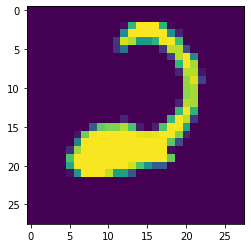

In [48]:
'''
성능 확인을 위해
Ctrl+Enter를 이용하여
반복 실행 해보자!
'''

id = rd.randrange(0,10000)

print(f'id = {id}'.format(id))
print(f'다음 그림은 숫자 {test_y.argmax(axis=1)[id]} 입니다.')
print(f'모델의 예측 : {single_pred_test[id]}')
print(f'모델의 카테고리별 확률 : {np.floor(pred_test[id]*100)}')

if test_y.argmax(axis=1)[id] == single_pred_test[id] :
    print('정답입니다')
else : 
    print('틀렸어요')
    
plt.imshow(test_x[id].reshape([28,-1]))
plt.show()

id = 1459
다음 그림은 숫자 2 입니다.
모델의 예측 : 3
모델의 카테고리별 확률 : [ 0.  0.  4. 94.  0.  0.  0.  1.  0.  0.]
틀렸어요


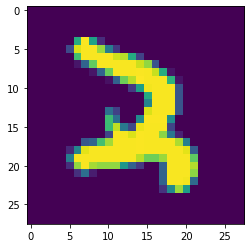

In [47]:
'''
틀린 것만 관찰해보자!

Ctrl+Enter를 이용하여
반복 실행 해보자!
'''

true_false = (test_y.argmax(axis=1) == single_pred_test)
f_id = np.where(true_false == False)[0]
f_n = len(f_id)

id = f_id[rd.randrange(0,f_n)]

print(f'id = {id}'.format(id))
print(f'다음 그림은 숫자 {test_y.argmax(axis=1)[id]} 입니다.')
print(f'모델의 예측 : {single_pred_test[id]}')
print(f'모델의 카테고리별 확률 : {np.floor(pred_test[id]*100)}')

if test_y.argmax(axis=1)[id] == single_pred_test[id] :
    print('정답입니다')
else : 
    print('틀렸어요')
    
plt.imshow(test_x[id].reshape([28,-1]))
plt.show()

In [42]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 32)        9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 12, 12, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 12, 12, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 12, 12, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 12, 12, 64)        36928     
                                                        

# 내가 쓴 숫자도 인식할까?

### 내 그림 파일을 업로드 해둔 곳으로 가자!

## 구글 드라이브에 내가 그림판에서 쓴 숫자 그림파일을 업로드해두자!
## 그리고 그 경로로 찾아들어가자!

**경로에 대하여**
1. my_data폴더를 구글드라이브에 바로 만들어둔다.
2. my_data폴더 안에 my_mnist폴더를 만든다.
3. 이미지를 그림판으로 제작하고, my_mnist라는 폴더안에 업로드한다.
4. 5초 정도 여유를 갖자.
5. 아래 코드들을 실행한다

In [49]:
# 이 코드가 있으면 내 구글 드라이브와 연동된다! 
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [52]:
# 폴더 목록을 가져온 것이고 drive라는 게 생겼고
# ls

NameError: ignored

In [53]:
cd /content/drive/MyDrive/my_data
# 구글 코랩은 content라는 위치에서 맨 처음에 시작한다.

NameError: ignored

In [ ]:
ls

### 이미지를 불러와보자

In [ ]:
import glob
from tensorflow.keras.preprocessing import image

In [ ]:
files = glob.glob('my_mnist/*')

- 톤을 바꾸는 태그

In [ ]:
img = image.load_img(files[0], color_mode='grayscale', target_size = (28,28) )
img = image.img_to_array(img)
plt.imshow(img.reshape(img.shape[0],img.shape[1]), cmap='Greys'  )
plt.show()

In [ ]:
img = 255-img

- 

In [ ]:
plt.imshow(img.reshape(img.shape[0],img.shape[1]), cmap='Greys'  )
plt.show()

In [ ]:
model.predict(img.reshape((-1,28,28,1)))[0].argmax()

### 이미지가 여러 장이라면

In [ ]:
images = []

for path in files :
    img = image.load_img(path, color_mode='grayscale', target_size = (28,28) )
    img = image.img_to_array(img)
    img = 255-img
    images.append(img)

images = np.array(images) # 넘파이 어레이화

In [ ]:
pred = model.predict(images)

for i in range(images.shape[0]) :
    print('====================================')
    print(f'모델의 예측 : {pred[i].argmax()}')
    print(f'모델의 카테고리별 확률 : {np.floor(pred[i]*100)}')
    plt.imshow(images[i].reshape(28,28) , cmap='Greys')
    plt.show()



---
### flow_from_directory


- 우리가 만든 손글씨 이미지를 증강시키고 그 증강된 이미지에 대해서 저장하고 
- 또 모델에 적용해 볼거야
* 


In [54]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [56]:
idg = ImageDataGenerator(rotation_range=25,
                         shear_range = 0.1,
                         zoom_range = 0.1,
                         horizontal_flip = True,
                         vertical_flip = True,
                         width_shift_range = 0.1,
                         height_shift_range=0.1
                         )

In [ ]:
# train_idg.fit(x_train)

In [ ]:
!mkdir /content/temp/

In [ ]:
idg.flow_from_directory('/content/drive/MyDrive/my_data/my_mnist',
                        save_to_dir = '/content/temp/', # 저잗도 좀 하겠습니다.
                        save_prefix = 'temp',
                        save_format = 'jpg',
                        target_size = (28, 28), # 폴더 내부에 있는 타겟 사이즈에 대해서 조절해줌
                        color_mode = 'grayscale', # 왜? 흑백으로 하고 있거든.
                        )

In [ ]:
model.fit(train_idg, epochs = 1, verbose = 1)